<center>
<hr>
<h1>Digital Epidemiology</h1>
<h2>Master in Data Science - Sapienza University</h2>
<h2>A.A. 2016/17</h2>
<h2>Paolo Tamagnini</h2>
<h3>ASSIGNMENT #2</h3>
<hr>
</center>

In [1]:
# Paolo Tamagnini
# paolotamag@gmail.com
# 1536242

# -*- coding: utf-8 -*-
import pandas as pd
import gzip
import urllib
import numpy as np
from os import listdir
import csv
import time
import os
from bs4 import BeautifulSoup
import urllib2
import networkx as nx
import matplotlib.pyplot as plt
import sklearn.linear_model
from sklearn.cross_validation  import cross_val_predict
import itertools

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
#to show progress in the long iterations:
def timer(start,end):
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    return "{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds)

#to look for rows relative to the pages of interest in the .gz dataframes
def process(df):
    df1 = df.loc[df[1].isin(lista_pagine)]
    df3 = df1.loc[df[0].isin(["it","it.mw"])]
    #df2 = df.loc["Vacccino" in df[1][0]]
    if len(df3)>0:
        #print df3
        return df3
    
#to see if a number is float or not
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

#to compute root mean sqaure error
def RMSE(p):
    somma = 0
    p_len = len(p)
    for i in range(0,p_len):
        somma+=(p[i]-df_x_y['Influnet_norm'][i])**2
    return np.sqrt(somma / p_len)

### Part 2.2
<p>The first codes regard the long downloads and computation of the wikimedia .gz files. Because of lack of time I had to select just 13 hours/files per day of the 3 months of 2016 where there was the peak of influenza (January, February and March).</p>
<p>I start from this point because it is at the beginning where I make sure that I am selecting just clicks of italian pages ("it", "it.mw") that happen between 9.00 am and 9.00 pm UTC. This means between the 10 am and 10 pm of the italian time. This way I am selecting just italian pages clicked mostly by people living in Italy, taking out some clicks of italians living in other time zones.</p> 

In [ ]:
#load all files from influnet and output a single csv 
#containing the 3 months of the 2016 peak (Jan,Feb,March)

paths = []
names = os.listdir('../influnet/data')
for i in names:
    path = '../influnet/data/'+i
    paths.append(path)
listDf = []
for x in paths:
    df = pd.read_csv(x, delimiter=' ',skiprows=[0], header=None, usecols=range(0,5))
    df.columns = col
    listDf.append(df)
sett = []
for i in range(1,20):
    sett.append("2016-"+"%02d" % (i,))
ground_truth = pd.concat(listDf)
threeMonthDf = []
for x in sett:
    dfGT = ground_truth.loc[ground_truth['Settimana'] == x]
    if len(dfGT) >0 :
        threeMonthDf.append(dfGT)
threeMonthDf = pd.concat(threeMonthDf)
threeMonthDf.to_csv('ground_truth_2016.csv',sep=',', index = False)

In [ ]:
#download every file .gz from website that describes hours within 9 am to 9 pm (UTC)
#store them in a proper folder and skip if already downloaded

fromYear = 2016
toYear = 2016
fromMonth = 1
toMonth= 3

link = "https://dumps.wikimedia.org/other/pagecounts-raw/"
years = range(fromYear,toYear+1)
links = []
for y in years:
    links.append(link+str(y))
months = range(fromMonth,toMonth+1)
months_links = []
for x in zip(links,years):
    l = x[0]
    y = x[1]
    for m in months:
        months_links.append(l+"/"+str(y)+"-"+"%02d" % (m,))
final_links = []
for l in months_links:
    print l
    while True:
        try:
            response = urllib2.urlopen(l)
            html = response.read()
            soup = BeautifulSoup(html, 'html.parser')
            for link in soup.find_all('a'):
                final_links.append(l+"/"+link.get('href'))
            print 'success'
            break
        except urllib2.HTTPError:
            print 'page not found'
            break
            
full_size = len(final_links)
st = time.time()
for ilink in range(0,full_size):
    ll = final_links[ilink]
    
    llsl = ll.split("/")
    lenlink = len(llsl)
    folderAnno = llsl[lenlink-3]
    folderMese = llsl[lenlink-2]
    fileName = llsl[lenlink-1]
    folderName = "download/"+folderAnno+"/"+folderMese+"/"
    name = folderName+llsl[lenlink-1]


    dirMese = os.path.dirname(folderName)
    if not os.path.exists(folderName):
        os.makedirs(folderName)

    print name
    if fileName[len(fileName)-2:len(fileName)] in ['gz'] and not os.path.isfile(name) :
        hour = int(ll[len(ll)-9:len(ll)-7])
        if hour >= 9 and hour <= 21:
            print "---> downloading.."
            urllib.urlretrieve(final_links[ilink], name)
            print
            print("ELAPSED TIME:",timer(st,time.time()))
            perc = float(ilink+1)/full_size*100
            print("PROGRESS:",ilink,"/",full_size,"(",int(perc),"%)")
            estim = (((time.time()-st)*(100 - perc))/perc)

            print("ETA:",int(estim/3600) ,"h",int((estim%3600)/60),"m")
            print
        else:
            print "---> too dark for wiki.."

    elif os.path.isfile(name):
        print "---> already downloaded."
    else:
        print "---> skipped."


### Part 2.1
<p>Except the pages advised by the assignment, I crawl in the network of linked pages of Wikipedia and retrieve the most relevant ones. To do so starting from the "Influenza" page and I get all the linked pages. The I do the same thing for all the pages I found.</p>
<p>At this point the graph is too big and it is necessary to do some pruning. Indeed I remove all the nodes that are not connected to at least 130 neighbors of "Influenza". This way we have a set of pages that represents the hard core of the graph. This means pages that are really popular in the local wiki graph of "Influenza".</p>
<p>The found pages are:</p>
<ul>
<li>"Bronchite"</li>
<li>"Broncopneumopatia_cronica_ostruttiva"</li>
<li>"SARS"</li>
<li>"Asma"</li>
<li>"Faringite_streptococcica"</li>
<li>"Rinite"</li>
<li>"Croup"</li>
<li>"Influenzavirus_C</li>
</ul>
<p>It is clear that those pages are not directly related with what people would look for in the case are sick of "Influenza", but they can help access the global trend of the wiki network since they are the most likely clicked by people exploring Wikipedia because of all their links. Furthermore in the case a sick person would start exploring the network from the influenza page there is higher chance it would click at least one of those pages, theoretically of corse.</p>

In [ ]:
#crawl starting from the wiki italian page for influenza using just link to other pages of related topic
#do this twice: crawl from influenza to all linked pages and do it again for each of them
#store all information to reproduce the graph

wiki_things = ['Aiuto:','PMID','ISBN','File:','Discussioni_modulo:','Speciale:','Categoria:','Template:',"Portale:"]
linksis = ["https://it.wikipedia.org/wiki/Influenza"]
origin = 'https://it.wikipedia.org'
d_page_link = {}
links_store = []
pages_store = []
where_when_what = []
i = 0
k = 2
csv_cycle_all = []
while i < k:
    g = 0
    links = []
    csv_cycle =[]
    for l in linksis:
        print i,l
        while True:
            try:
                response = urllib2.urlopen(l)
                html = response.read()
                soup = BeautifulSoup(html, 'html.parser')
                
                for link in soup.find_all('a'):
                    while True:
                        try:
                            nome_su_csv = link.get('href')
                            wikiId = nome_su_csv[:6]
                            properWiki = nome_su_csv[6:]
                            linka = origin+link.get('href')
                            pagia = link.get('title')
                            
                            if (wikiId in ['/wiki/'] and 
                                "Wikipedia" not in pagia and 
                                pagia not in ['.doc'] and 
                                not any([wk in properWiki for wk in wiki_things]) and 
                                not is_number(properWiki)):
                                
                                d_page_link[pagia] = linka
                                where_when_what.append((i,l[30:],properWiki))
                                csv_cycle.append(properWiki)
                                links.append(linka)
                                links_store.append(linka)
                                pages_store.append(pagia)
                                
                            break
                            
                        except TypeError:
                            #print'no class'
                            break
                print 'success, ciclo: ',i
                print "# link ciclo: ", len(linksis) 
                print "Progress:", g/float(len(linksis))*100, " %"
                print
                g += 1
                break
            except urllib2.HTTPError:
                print 'page not found'
                break
    links = sorted(set(links))
    linksis = np.copy(links)
    csv_cycle_all.append(csv_cycle)
    i += 1
    


In [ ]:
#the graph is huge so we need to do some pruning: 
#take away nodes that are not highly connected to the pages directly linked from influenza
#to reach a number of pages small enough i had to remove all nodes that didnt have 
#at least 130 connecetions with the neighbourss of influenza
#at the end print those pages that represnts more or less the hard core of the graph
G=nx.Graph()

for x in where_when_what:
    from_page = x[1]
    to_page = x[2]
    cycle = x[0]
    G.add_edge(from_page,to_page)
        
print "da: ", len(G.nodes())
uno = set(csv_cycle_all[0])
due = set(csv_cycle_all[1])
tre = due - uno

thrk = 130
#thrk = 1

toDelete = []
for x in G.nodes():
    hesfine = False
    c = 0
    for y in G.neighbors(x):

        if y in uno and c == thrk :
            hesfine = True
            break
        elif y in uno and c < thrk:
            c+=1
    if not hesfine:
        toDelete.append(x)
G.remove_nodes_from(toDelete)
print "a: ", len(G.nodes())
for x in G.nodes():
    print x

In [ ]:
#to analyse each gz file we downloaded that are of interest,
#we scroll chunk by chunk the huge df that is within each of them
#when we find rows related to pages of interest we save them
#in the end we concatenate the rows we found and we save them in  a csv
#the pages of interest are the ones that are adivced by the assignment and
#the ones we found by crawling in wikipedia

fromYear = 2015
toYear = 2016
fromMonth = 1
toMonth = 12
anni = range(fromYear,toYear+1)
mesi = range(fromMonth,toMonth+1)
pathes = []
for i in anni:
    for j in mesi:
        path = 'download/'+str(i)+"/"+str(i)+"-"+"%02d" % (j,)+"/"
        pathes.append(path)
rightPath = []
for i in range(0,len(pathes)):
    while True:
        try:
            files = listdir(pathes[i])
            for x in files:
                #if int(x[20:22]) >=9 and int(x[20:22])<=21:
                rightPath.append(pathes[i]+"/"+x)
            break
        except WindowsError:
            print "folder not fond:",pathes[i]
            break
            
st = time.time()
lista_df_res = []
full_size = len(rightPath)
for i in range(0,full_size):
    
    path = rightPath[i]
    
    print
    print path
    print
    
    dfResult = pd.DataFrame()

    all_together = path[len(path)-18:len(path)-3]

    lista_pagine_ass = ["Vaccino_antinfluenzale",'Vaccino_influenza_stagionale','Influenza',
                        'Vaccino','Febbre',"Rinorrea","Mialgia","Cefalea","Vomito",
                    "Paracetamolo","Vaccino_antinfluenzale#Vaccino_influenza_stagionale"]
    lista_pagine_tot = lista_pagine_ass + ["Bronchite","Broncopneumopatia_cronica_ostruttiva", "SARS", "Asma",
                    "Faringite_streptococcica","Rinite","Croup","Influenzavirus_C","Influenza"]
    k = 1


    chunksize = 10 ** 6
    reader = pd.read_csv(path, delimiter = ' ', header=None, quoting=csv.QUOTE_NONE, 
                         encoding = 'utf-8', chunksize=chunksize, compression='gzip')
    while True:
        try:
            for chunk in reader:
                
                #print "--> chunk ",k

                res = process(chunk)
                dfResult = dfResult.append(res, ignore_index = True)

                k += 1
            numRigh = len(dfResult)
            
            if numRigh > 0:
                
                data = np.repeat(all_together,numRigh)
                dfResult.columns = ["paese", "pagina", "count","size"]
                dfResult['data'] = data
                lista_df_res.append(dfResult)
                
                print
                print("ELAPSED TIME:",timer(st,time.time()))
                perc = float(i+1)/full_size*100
                print("PROGRESS:",i,"/",full_size,"(",int(perc),"%)")
                estim = (((time.time()-st)*(100 - perc))/perc)
                print("ETA:",int(estim/3600) ,"h",int((estim%3600)/60),"m")
                print
                
            break
            
        except pd.parser.CParserError:
            print
            print "------------------------------"
            print "weird encodiing in file, skip!"
            print "------------------------------"
            print

finalDf = pd.concat(lista_df_res)
finalDf.to_csv("selection_pages.csv", sep=',', index = False)


In [ ]:
#we load now the csv produced in the last step
#to process it and have a row per week with the right amount of clicks.
#to do so we just find a way to merge rows belong to the same week
#we do this by merely counting from the first of january 2016 whih was a friday
#the output is a csv that can be finally used to compare it with the influnet data loaded
#in the first step

df_all = pd.read_csv('selection_pages.csv')
numRighFinalDf = len(df_all)
oraMattino = 9
oraSera = 21
ore = []
for i in range(0,numRighFinalDf):
    ore.append(int(df_all["data"][i][9:11]))
df_all['ora'] = ore
df_all = df_all[df_all['ora']>oraMattino]
df_all = df_all[df_all['ora']<oraSera]
numRighFinalDf = len(df_all)
df_all = df_all.reset_index()
settNames = ["l","ma","me","g","v","s","d"]
daysett = 4
num_sett = 1
d_data_sett = {}
for m in range(1,4):
    if m == 2:
        maxMese = 29
    else:
        maxMese = 31
    for d in range(1,maxMese+1):
        if daysett == 7:
            daysett = 0
            num_sett += 1
        d_data_sett[(m,d)] = (num_sett,settNames[daysett])
        daysett += 1
giorni_num_sett = []
giorni_nomi_sett = []
for i in range(0,numRighFinalDf):
    weird_date = df_all['data'][i]
    mese = int(weird_date[4:6])
    giorno = int(weird_date[6:8])
    sett = d_data_sett[(mese,giorno)][0]
    giorSett = d_data_sett[(mese,giorno)][1]
    giorni_num_sett.append(sett)
    giorni_nomi_sett.append(giorSett)

df_all['#sett'] = giorni_num_sett
df_all['giorn_sett'] = giorni_nomi_sett



lista_pagine_ass = ["Vaccino_antinfluenzale",'Vaccino_influenza_stagionale',
                'Influenza','Vaccino','Febbre',"Rinorrea","Mialgia",
                "Cefalea","Vomito","Paracetamolo",
                "Vaccino_antinfluenzale#Vaccino_influenza_stagionale"]

lista_pagine_wiki_crawl = ["Bronchite","Broncopneumopatia_cronica_ostruttiva", "SARS", "Asma",
                "Faringite_streptococcica","Rinite","Croup","Influenzavirus_C","Influenza"]
lista_pagine = lista_pagine_ass+lista_pagine_wiki_crawl

d_pag_df = {}
for x in lista_pagine:
    d_pag_df[x] = df_all.loc[df_all['pagina']==x]
    
d_aggrdf_perPag = {}
for x in lista_pagine:
    aggr_df = pd.DataFrame()
    df_Now = d_pag_df[x]
    settimane_trovate = list(set(df_Now["#sett"]))
    settimana_counts = []
    for s in settimane_trovate:
        count = np.sum(df_Now.loc[df_Now['#sett'] == s]['count'])
        settimana_counts.append(count)
    
    aggr_df['sett'] = settimane_trovate
    aggr_df['count'] = settimana_counts
    d_aggrdf_perPag[x] = aggr_df
    
bel_df = pd.DataFrame()
pagine = []
countss = []
sett = []
for x in lista_pagine:
    for jh in range(0,len(d_aggrdf_perPag[x])):
        pagine.append(x)
        sett.append(d_aggrdf_perPag[x]['sett'][jh])
        countss.append(d_aggrdf_perPag[x]['count'][jh])
bel_df['pagina'] = pagine
bel_df['settimana'] = sett
bel_df['click'] = countss

full = sorted(set(bel_df['settimana']))
all_rows = len(bel_df)
for x in lista_pagine:
    sett_of_page = list(bel_df.loc[bel_df['pagina']==x]['settimana'])
    for h in full:
        all_rows = len(bel_df)
        if h not in sett_of_page:
            print 'found missing:',x,' - ',h
            bel_df.loc[all_rows] = [x,h,0]

bel_df.to_csv("aggregated_data_click_week.csv", sep=',', index = False)


In [4]:
#honestly because of the fact this work took several days and it wasn't done all together 
#the input is made of 3 different csv instead of just 2
#this because i first got a csv with the pages adviced by the assignment and just after 
#the crawling i could gather all the ones close to the pae influenza

df_wiki1 = pd.read_csv('page_week_click.csv')
df_wiki2 = pd.read_csv('page_week_click_crawl.csv')
df_grTr = pd.read_csv('ground_truth_2016.csv')

#then as follows there is the code necessary to merge those two dataframes displaying different pages

lista_pagine1 = ["Vaccino_antinfluenzale",'Vaccino_influenza_stagionale',
                'Influenza','Vaccino','Febbre',"Rinorrea","Mialgia",
                "Cefalea","Vomito","Paracetamolo"]
lista_pagine2 = ["Bronchite","Broncopneumopatia_cronica_ostruttiva", "SARS", "Asma",
                "Faringite_streptococcica","Rinite","Croup","Influenzavirus_C","Influenza"]
#merging pages list
lista_pagine2new = lista_pagine2[:len(lista_pagine2)-2]
df_wiki = df_wiki1.append(df_wiki2[df_wiki2['pagina'].isin(lista_pagine2new)])
lista_pagine = lista_pagine1 + lista_pagine2new

#set time index for GroundTruth

d_week_date = {}
pureDate = []
day = 1
month = 1
week_old = 1
for x in df_grTr['Settimana']:
    year = int(x[:4])
    week = int(x[5:])
    if month == 2:
        monthMax = 28
    else:
        monthMax = 31
    if week == week_old + 1:
        day += 7
    if day >monthMax:
        day = 1
        month+=1
    timecode = str(year)+"-"+str(month)+"-"+str(day)
    time = timecode
    d_week_date[week] = time
    pureDate.append(time)
    week_old = week
df_grTr = df_grTr.set_index(pd.DatetimeIndex(pureDate))

#set time index for dfwiki one page per row

pureDate = []
day = 1
month = 1
week_old = 1
starting = True
for x in df_wiki['settimana']:

    year = 2016
    week = int(x)
    if not starting and week == 1:
        day = 1
        month = 1
        week_old = 1
    if month == 2:
        monthMax = 28
    else:
        monthMax = 31
    if week == week_old + 1:
        day += 7
    if day >monthMax:
        day = 1
        month+=1
    timecode = str(year)+"-"+str(month)+"-"+str(day)
    pureDate.append(timecode)
    week_old = week
    starting = False
df_wiki["fancy_date"] = pureDate
num_av_week = np.min([np.max(df_wiki['settimana']),len(df_grTr)])
list_influnet = []
for x in df_grTr["Totale_Casi"]:
    list_influnet.append(x*1000)
df_grTr["Totale_Casi"] = list_influnet


### PART 1.1 - 1.2 - 2.3 
<p>The correlation has been computed for each page (both the pages gathered from the Wikipedia network and the pages advised from the assignment). The clicks correlation and plot for "Influenza" page are within this list, and the correlation is significant, at least for this 3 months. What ever page has correlation coefficient below 0.7 will not be used in the further steps.</p> 
<p>The long output has a plot and correlation coefficient value for each of those pages:</p>

<p>"Vaccino_antinfluenzale",'Vaccino_influenza_stagionale','Influenza','Vaccino','Febbre',"Rinorrea","Mialgia",
"Cefalea","Vomito","Paracetamolo","Bronchite","Broncopneumopatia_cronica_ostruttiva", "SARS", "Asma",
"Faringite_streptococcica","Rinite","Croup","Influenzavirus_C","Influenza"</p>


Vaccino_antinfluenzale --> corr coeff between click and influnet:  0.478638645664


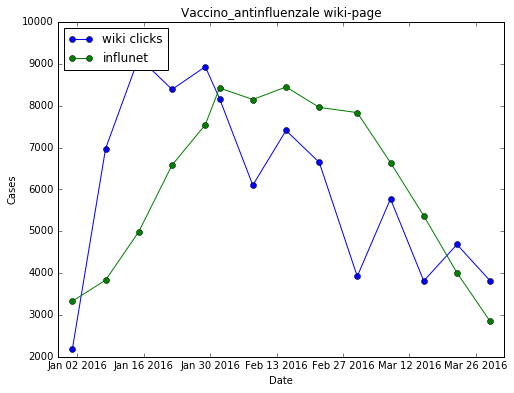

Vaccino_influenza_stagionale --> corr coeff between click and influnet:  0.487280204228


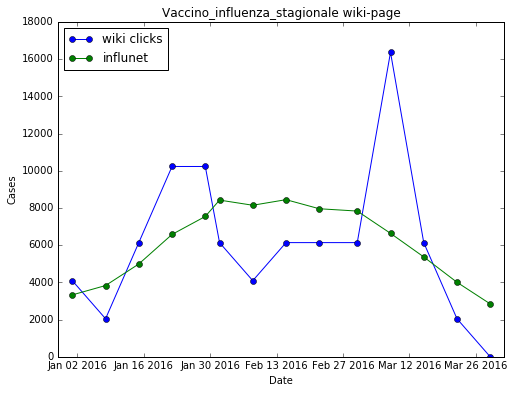

Influenza --> corr coeff between click and influnet:  0.757485024685


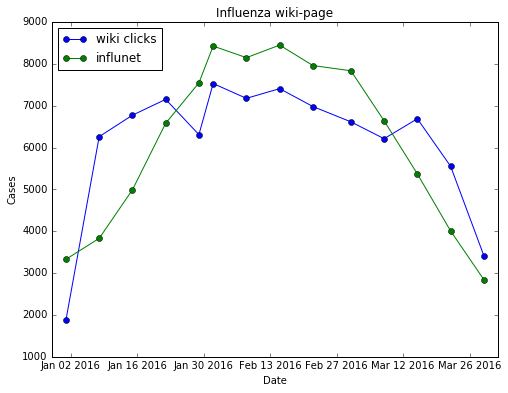

Vaccino --> corr coeff between click and influnet:  0.803617736136


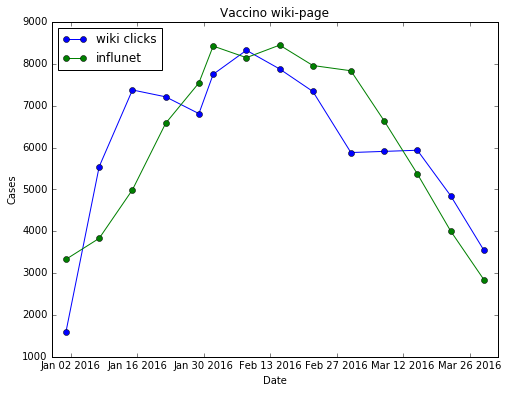

Febbre --> corr coeff between click and influnet:  0.822453302506


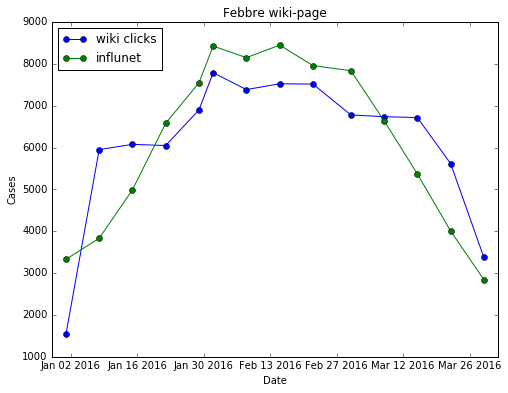

Rinorrea --> corr coeff between click and influnet:  0.608168931126


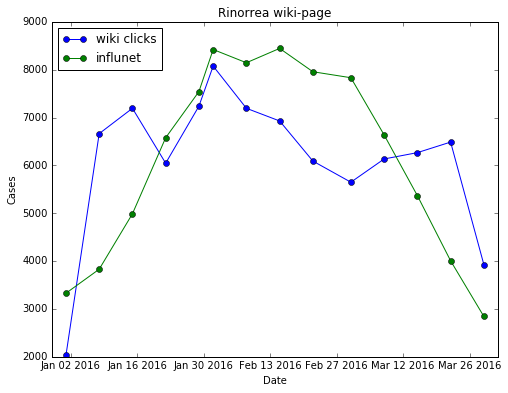

Mialgia --> corr coeff between click and influnet:  0.760859086407


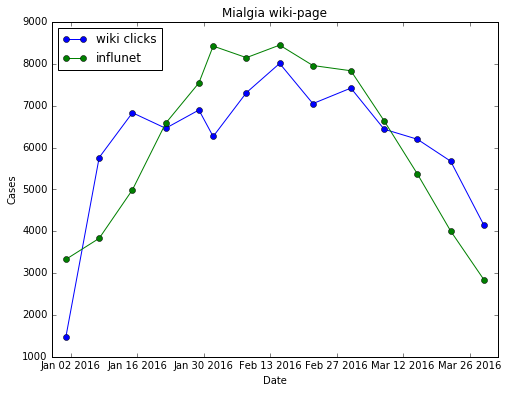

Cefalea --> corr coeff between click and influnet:  0.865822248419


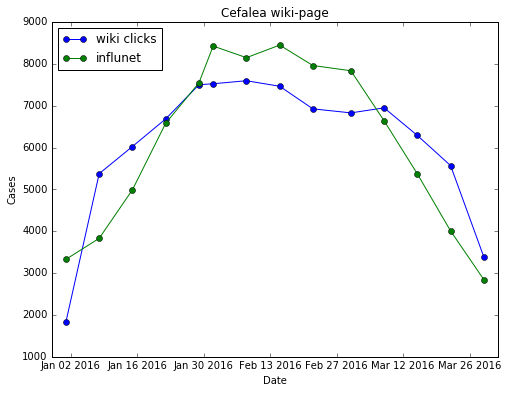

Vomito --> corr coeff between click and influnet:  0.648734937528


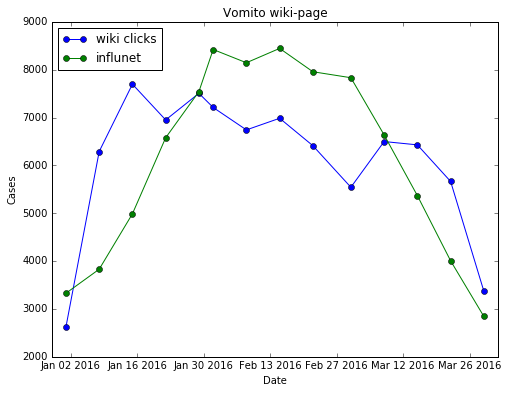

Paracetamolo --> corr coeff between click and influnet:  0.766085519069


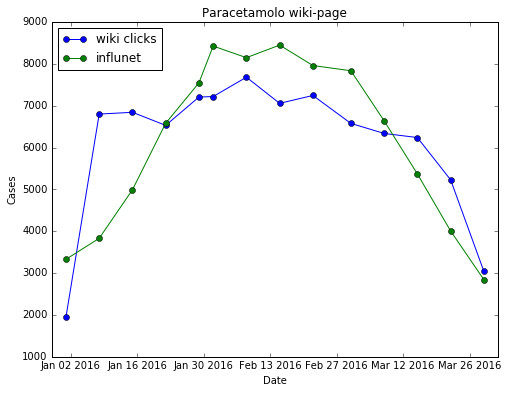

Bronchite --> corr coeff between click and influnet:  0.689485771067


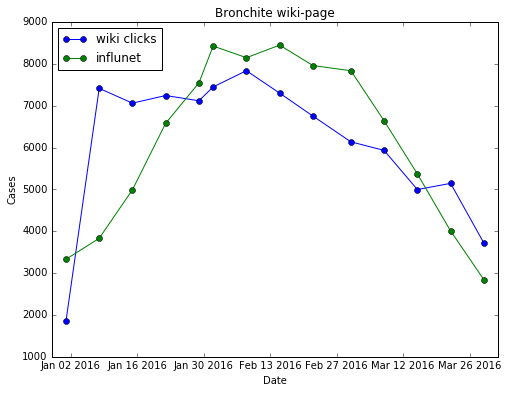

Broncopneumopatia_cronica_ostruttiva --> corr coeff between click and influnet:  0.789088323299


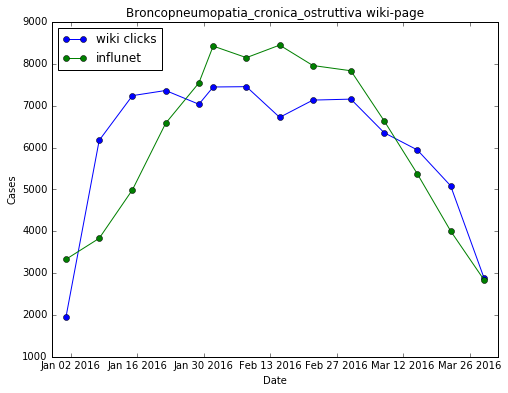

SARS --> corr coeff between click and influnet:  0.796688059233


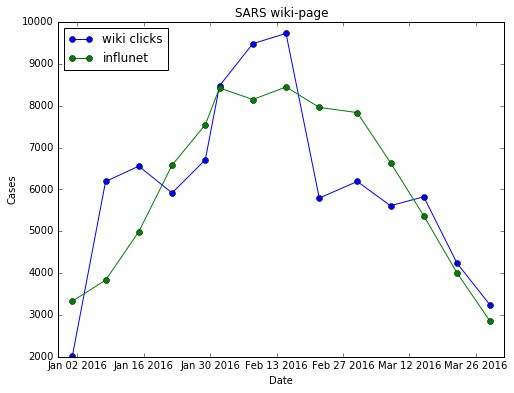

Asma --> corr coeff between click and influnet:  0.756597538562


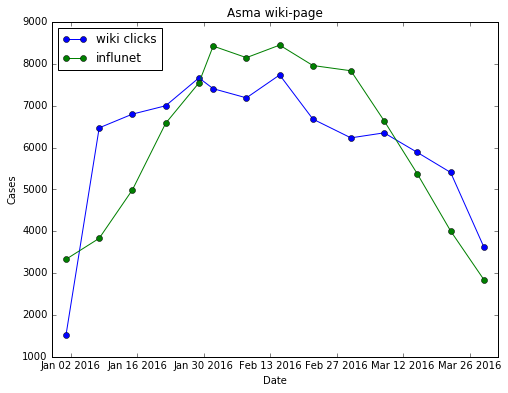

Faringite_streptococcica --> corr coeff between click and influnet:  0.701697861215


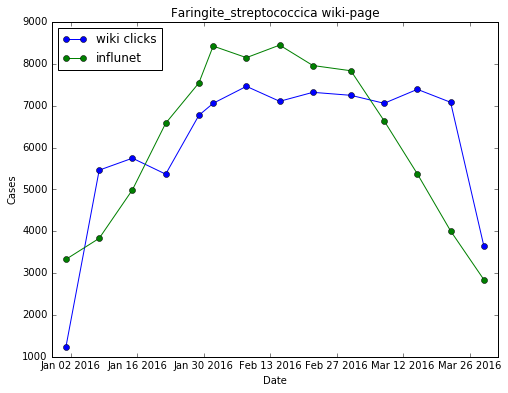

Rinite --> corr coeff between click and influnet:  0.761706242589


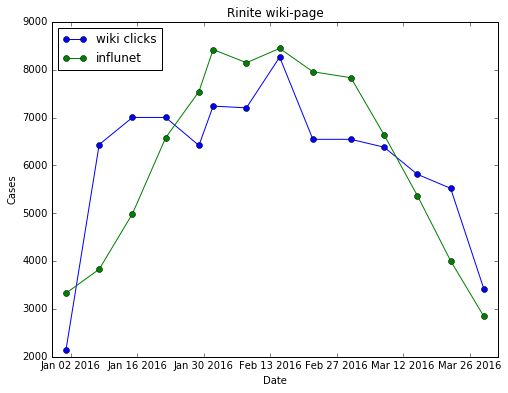

Croup --> corr coeff between click and influnet:  0.761317374338


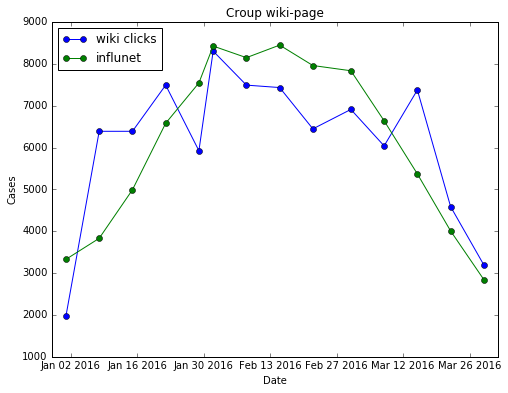

In [5]:
#at this point we can compute the correlation between the clicks of each pages and the influnet data
#the result is in the print
badPages = []
num_av_week = np.min([np.max(df_wiki['settimana']),len(df_grTr)])
for p in lista_pagine:
    dfInf = df_wiki.loc[df_wiki['pagina']==p]
    dfInf = dfInf.set_index(pd.DatetimeIndex(dfInf["fancy_date"]))

   
    corrFull = np.corrcoef(df_grTr['Totale_Casi'][0:14],dfInf['click'])[1,0]
    print p,"--> corr coeff between click and influnet: ",corrFull
    if corrFull < 0.7:
        badPages.append(p)



    x1 = df_grTr['Totale_Casi'][0:num_av_week]
    sommaInflunet = np.sum(df_grTr["Totale_Casi"][0:num_av_week])
    x2 = dfInf['click']
    x2 = x2/np.sum(x2)*sommaInflunet

    plt.figure(figsize=(8, 6))
    plt.xlim([pd.Timestamp("2015-12-29"),pd.Timestamp("2016-04-01")])
    plt.plot(x2, label = "wiki clicks",marker ='o')

    plt.plot(x1,marker ='o', label = "influnet")

    plt.ylabel('Cases')
    plt.xlabel('Date')
    plt.title(p+" wiki-page")

    plt.legend(loc=2)

    plt.show()

In [6]:
#we remove now all the pages where the correlation is too poor (<0.7)
lista_pagine = list(set(lista_pagine1 + lista_pagine2new) - set(badPages))
df_wiki = df_wiki[df_wiki['pagina'].isin(lista_pagine)]

In [7]:
#we now build a dataframes that displays the pages as input features and the influnet data as output for each week

columns_list = []
for p in lista_pagine:
    df_pagina  = df_wiki.loc[df_wiki['pagina']==p]
    list_column = []
    for i in range(1,num_av_week+1):
        list_column.append(int(df_pagina.loc[df_pagina['settimana']==i]["click"]))
    columns_list.append(list_column)
    
df_x_y = pd.DataFrame()
for i in range(0,len(lista_pagine)):
    df_x_y[lista_pagine[i]] = columns_list[i]

newpuredate = []
for i in range(0,len(df_x_y)):
    newpuredate.append(d_week_date[i+1])
df_x_y = df_x_y.set_index(pd.DatetimeIndex(newpuredate))

df_x_y["Influnet"] = df_grTr["Totale_Casi"][0:num_av_week]
    
df_x_y.head()

,Broncopneumopatia_cronica_ostruttiva,Influenza,Febbre,Faringite_streptococcica,Cefalea,Rinite,Paracetamolo,Asma,Vaccino,Croup,SARS,Mialgia,Influnet
2016-01-01,255,154,221,52,153,117,455,152,175,34,66,68,3329.0
2016-01-08,808,513,855,229,448,352,1589,650,608,110,203,264,3831.0
2016-01-15,948,555,873,241,502,383,1599,683,809,110,215,313,4990.0
2016-01-22,964,586,869,225,557,383,1526,703,791,129,194,296,6580.0
2016-01-29,921,517,991,284,625,351,1684,770,747,102,220,316,7545.0


In [8]:
# we also compute a normalized matrix that will be used directly in the regression model
matrix_df = np.array(df_x_y)
num_of_pages = len(lista_pagine)
for x in range(0,len(matrix_df[0,:])):
    matrix_df[:,x] = matrix_df[:,x]/np.sum(matrix_df[:,x])

In [9]:
#we now compute all the different test groups and relative train groups that will be used in the cross validation
#the approach is the following:
#we want to predict the week 14 (week of the following day: 2016-03-15)
#we ignore then to have the influnet data of this week
#we can use then from week #1 (2016-01-01) to week #13 (2016-03-22) to train and test pur model
#we split the the first 11 weeks with k-fold cross validation permutating first the order of the rows

settimana_t = 14
test_sets = []
train_sets = []
randomDF = pd.DataFrame()
randomDF['cases'] = matrix_df[:settimana_t-1,len(matrix_df[0])-1]
for i in range(0,num_of_pages):
    randomDF[lista_pagine[i]] = matrix_df[:settimana_t-1,i]
randomDF = randomDF.reindex(np.random.permutation(randomDF.index))
num_av_week = len(randomDF)
y1random = np.array(randomDF['cases'])
y2random = np.array(randomDF[lista_pagine])
size_group = int(0.3*num_av_week)
change =  num_av_week%float(size_group)
print '# of istances that will never be in test: ',change

num_of_set = num_av_week/size_group
for crss in range(0,num_of_set):
    P_test = y1random[crss:crss+size_group]
    Q_test = y2random[crss:crss+size_group]
    P_train = np.concatenate((y1random[:crss],y1random[crss+size_group:]))
    Q_train = np.concatenate((y2random[:crss],y2random[crss+size_group:]))
    test_sets.append((P_test,Q_test))
    train_sets.append((P_train,Q_train))

print  'Cross validation groups computed.'
print 'number of test groups: ', num_of_set
print 'size of groups: ', size_group
print 'total number of istances available: ', num_av_week

# of istances that will never be in test:  1.0
Cross validation groups computed.
number of test groups:  4
size of groups:  3
total number of istances available:  13


In [10]:
#at this point we can run our linear regression once for every group
#then we can compute the average coefficients (1 for each feature) and intercept computed
betas = np.zeros((len(test_sets),num_of_pages+1))
i = 0
for x in zip(test_sets,train_sets):
    train_wiki = x[1][1]
    test_wiki = x[0][1]

    train_influ = x[1][0]
    test_influ = x[0][0]

    lr = sklearn.linear_model.LinearRegression()
    lr = lr.fit(train_wiki,train_influ)

    betas[i,:num_of_pages]=lr.coef_
    betas[i,num_of_pages] = lr.intercept_
    i +=1
conca = []
for j in range(0,num_of_pages+1):
    conca.append(np.mean(betas[:,j]))
conca=np.array(conca)
war_matrix = np.c_[ matrix_df[:,:len(matrix_df[0])-1], np.ones(len(matrix_df))] 
print "coeffient:"
print conca[i:num_of_pages]
print "intercept:"
print conca[num_of_pages]

coeffient:
[ 1.61224595 -1.1969686  -1.28669058 -0.8925847   0.23815278  0.06790523
  0.35228687  0.66945613]
intercept:
0.0282302223724


### Part 3.1 - using all pages
<p>The first regression model that we use is then taking as features for each week the clicks of all the pages with correlation coefficient greater than 0.7. Every column of feature is normalized and also the output itself: the total number of flu cases that the influnet reports in the same week. Unfortunately we have only 14 weeks.</p>
<p>The plot below shows us, with the dashed red line, that we want to predict the 14th week by using all the weeks before. This means the model predicts the last week by ignoring completely the relative available ground truth data for it.</p>
<p>The linear regression model is then doing a k-fold cross validation with k = 4 with the data of the first 13 weeks. Once the model has been trained and test with each of the group, it predicts the last week by using the average coefficient and the average intercept computed.</p>
<p>The output shows also the root mean square error computed over all the weeks. As we can see the performance is not too great and this is because we used all the pages as feature. The next step will be to find the right combination of pages that reduces the RMSE.</p>

RMSE:  0.00889176062642


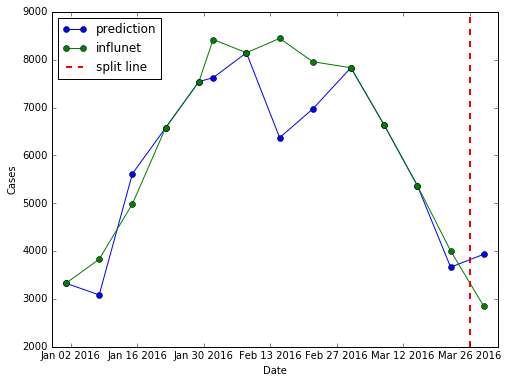

In [12]:
# the result is the following plot where the dashed red line is splitting the weeks between those that are used in the 
# cross validation and those that aren't cause we pretend are the ones we are actually predicting 
# and without the influnet data.
# remember that in this case we are using every page clicks with a decent correlation as feature.
pred = np.dot(war_matrix,conca)
df_x_y["pred_norm"] = pred
df_x_y['Influnet_norm'] = matrix_df[:,num_of_pages]
rmse_error = RMSE(pred)
plt.figure(figsize=(8, 6))
plt.xlim([pd.Timestamp("2015-12-29"),pd.Timestamp("2016-04-01")])

plt.plot(df_x_y["pred_norm"]*sommaInflunet, marker = 'o', label= "prediction")
plt.plot(df_x_y['Influnet_norm']*sommaInflunet, marker = 'o', label='influnet')
plt.axvline(x=pd.Timestamp("2016-03-26"),linestyle ='dashed', color='r',linewidth=2.0, label="split line")
plt.legend(loc=2)
print "RMSE: ", rmse_error
plt.ylabel('Cases')
plt.xlabel('Date')
plt.show()

### Part 3.1 - right combination of pages
<p>What we do here is to try out every possible combination of pages and pick the one with the least RMSE. The result achieved is way better and the selected pages are:</p>
<ul>
<li>Febbre</li>
<li>Faringite_streptococcica</li>
<li>Cefalea</li>
<li>Asma</li>
<li>Vaccino</li>
<li>Croup</li>
<li>SARS</li>
<li>Mialgia</li>
</ul>
<p>As we can see we have a mixture of pages from both of the 2 initial groups: the ones adivsed by the assignment and the ones crawled out from the wiki network. This could point out that it is indeed of combination of people actually looking for direct explanations of their symptoms and that maybe guided from a collective ipocondria end up in  highly connected pages of serious disease like SARS. This is just a theory of course.</p>

The best combination of pages is:
['Febbre', 'Faringite_streptococcica', 'Cefalea', 'Asma', 'Croup', 'SARS', 'Mialgia']

RMSE: 0.00423508426431



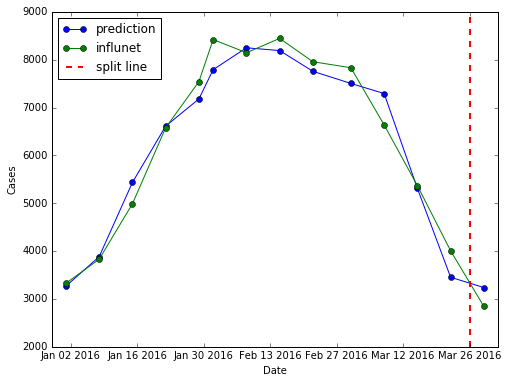

In [13]:
#the next step will be to compute the prediction with every possible combination of feature 
#to find the one that gives the best RMSE.
# the results are as follows:

list_index =range(0,num_of_pages)
comb = []
for L in range(0, len(list_index)+1):
    for subset in itertools.combinations(list_index, L):
            comb.append(list(subset))
comb = comb[1:]

RMSE_best = 1000
for c in comb:
    num_of_selected = len(c)
    betas = np.zeros((len(test_sets),num_of_selected+1))
    i = 0
    for x in zip(test_sets,train_sets):
        train_wiki = x[1][1]
        test_wiki = x[0][1]

        train_influ = x[1][0]
        test_influ = x[0][0]

        lr = sklearn.linear_model.LinearRegression()
        lr = lr.fit(train_wiki[:,c],train_influ)

        betas[i,:num_of_selected]=lr.coef_
        betas[i,num_of_selected] = lr.intercept_
        i +=1
    conca = []
    for j in range(0,num_of_selected+1):
        conca.append(np.mean(betas[:,j]))
    conca=np.array(conca)
    war_matrix = np.c_[ matrix_df[:,c], np.ones(len(matrix_df))] 
    pred = np.dot(war_matrix,conca)
    rmse_error = RMSE(pred)
    if RMSE_best>rmse_error:
        bestcomb = c
        RMSE_best = rmse_error
        best_pred = pred

print "The best combination of pages is:"
df_x_y['Influnet_norm'] = matrix_df[:,num_of_pages]
print [lista_pagine[h] for h in bestcomb]
print
print 'RMSE:', RMSE_best
print
df_x_y["pred_norm"] = best_pred
plt.figure(figsize=(8, 6))
plt.xlim([pd.Timestamp("2015-12-29"),pd.Timestamp("2016-04-01")])
plt.plot(df_x_y["pred_norm"]*sommaInflunet, marker = 'o', label= "prediction")
plt.plot(df_x_y['Influnet_norm']*sommaInflunet, marker = 'o', label='influnet')
plt.axvline(x=pd.Timestamp("2016-03-26"),linestyle ='dashed', color='r',linewidth=2.0, label="split line")
plt.legend(loc=2)
plt.ylabel('Cases')
plt.xlabel('Date')
plt.show()


### Part 3.2 - Intro
<p>It is time now to add more features to the data-frame in order to also compute the output given the values of the instance of the week before. To do this we must recompute the initial data-frames from the beginning so there will be some codes we have already shown is section 3.1 .</p>


In [40]:
#the next task is to add more features
#to do this we need to recompute everything to start with the right dataframe
df_wiki1 = pd.read_csv('page_week_click.csv')
df_wiki2 = pd.read_csv('page_week_click_crawl.csv')
df_grTr = pd.read_csv('ground_truth_2016.csv')
past_combination =['Febbre', 'Faringite_streptococcica', 'Cefalea', 'Asma', 'Croup', 'SARS', 'Mialgia']
lista_pagine1 = ["Vaccino_antinfluenzale",'Vaccino_influenza_stagionale',
                'Influenza','Vaccino','Febbre',"Rinorrea","Mialgia",
                "Cefalea","Vomito","Paracetamolo"]
lista_pagine2 = ["Bronchite", "SARS", "Asma",
                "Faringite_streptococcica","Rinite","Croup","Influenzavirus_C","Influenza"]

lista_pagine1 = [x for x in lista_pagine1 if x in past_combination]
lista_pagine2 = [x for x in lista_pagine2 if x in past_combination]

#both
lista_pagine2new = lista_pagine2
df_wiki = df_wiki1.append(df_wiki2[df_wiki2['pagina'].isin(lista_pagine2new)])
lista_pagine = lista_pagine1 + lista_pagine2new

#set time index for GroundTruth

d_week_date = {}
pureDate = []
day = 1
month = 1
week_old = 1
for x in df_grTr['Settimana']:
    year = int(x[:4])
    week = int(x[5:])
    if month == 2:
        monthMax = 28
    else:
        monthMax = 31
    if week == week_old + 1:
        day += 7
    if day >monthMax:
        day = 1
        month+=1
    timecode = str(year)+"-"+str(month)+"-"+str(day)
    time = timecode
    d_week_date[week] = time
    pureDate.append(time)
    week_old = week
df_grTr = df_grTr.set_index(pd.DatetimeIndex(pureDate))

#set time index for dfwiki one page per row

pureDate = []
day = 1
month = 1
week_old = 1
starting = True
for x in df_wiki['settimana']:

    year = 2016
    week = int(x)
    if not starting and week == 1:
        day = 1
        month = 1
        week_old = 1
    if month == 2:
        monthMax = 28
    else:
        monthMax = 31
    if week == week_old + 1:
        day += 7
    if day >monthMax:
        day = 1
        month+=1
    timecode = str(year)+"-"+str(month)+"-"+str(day)
    pureDate.append(timecode)
    week_old = week
    starting = False
df_wiki["fancy_date"] = pureDate
badPages = []
num_av_week = np.min([np.max(df_wiki['settimana']),len(df_grTr)])
list_influnet = []
for x in df_grTr["Totale_Casi"]:
    list_influnet.append(x*1000)
df_grTr["Totale_Casi"] = list_influnet
for p in lista_pagine:
    dfInf = df_wiki.loc[df_wiki['pagina']==p]
    dfInf = dfInf.set_index(pd.DatetimeIndex(dfInf["fancy_date"]))

   
    corrFull = np.corrcoef(df_grTr['Totale_Casi'][0:14],dfInf['click'])[1,0]

    if corrFull < 0.7:
        badPages.append(p)
lista_pagine = list(set(lista_pagine1 + lista_pagine2new) - set(badPages))
df_wiki = df_wiki[df_wiki['pagina'].isin(lista_pagine)]
df_x_y = pd.DataFrame()
columns_list = []
for p in lista_pagine:
    df_pagina  = df_wiki.loc[df_wiki['pagina']==p]
    list_column = []
    for i in range(1,num_av_week+1):
        list_column.append(int(df_pagina.loc[df_pagina['settimana']==i]["click"]))
    columns_list.append(list_column)
    
df_x_y = pd.DataFrame()
for i in range(0,len(lista_pagine)):
    df_x_y[lista_pagine[i]] = columns_list[i]

#############################################
#Adding features to the dataframe df_x_y
#############################################
    
newpuredate = []
for i in range(0,len(df_x_y)):
    newpuredate.append(d_week_date[i+1])
df_x_y = df_x_y.set_index(pd.DatetimeIndex(newpuredate))

df_x_y["Influnet"] = df_grTr["Totale_Casi"][0:num_av_week]
old_pages = []
d_oldpage_list = {}
for p in lista_pagine:
    d_oldpage_list[p+'_old'] = []
    old_pages.append(p+'_old')
d_oldpage_list['Influnet_old'] = []
for i in range(0,len(df_x_y)):
    if i > 0:
        d_oldpage_list['Influnet_old'].append(df_x_y["Influnet"][i-1])

    else:
        d_oldpage_list['Influnet_old'].append(np.nan)

    
    for j in range(0,len(lista_pagine)):
        if i >0:
            d_oldpage_list[old_pages[j]].append(df_x_y[lista_pagine[j]][i-1])
            
        else:
            d_oldpage_list[old_pages[j]].append(np.nan)
for p in lista_pagine:
    df_x_y[p+'_old'] = d_oldpage_list[p+'_old']
df_x_y['Influnet_old'] = d_oldpage_list['Influnet_old']
df_x_y.head()

,Febbre,Faringite_streptococcica,Cefalea,Asma,Croup,SARS,Mialgia,Influnet,Febbre_old,Faringite_streptococcica_old,Cefalea_old,Asma_old,Croup_old,SARS_old,Mialgia_old,Influnet_old
2016-01-01,221,52,153,152,34,66,68,3329.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-08,855,229,448,650,110,203,264,3831.0,221.0,52.0,153.0,152.0,34.0,66.0,68.0,3329.0
2016-01-15,873,241,502,683,110,215,313,4990.0,855.0,229.0,448.0,650.0,110.0,203.0,264.0,3831.0
2016-01-22,869,225,557,703,129,194,296,6580.0,873.0,241.0,502.0,683.0,110.0,215.0,313.0,4990.0
2016-01-29,991,284,625,770,102,220,316,7545.0,869.0,225.0,557.0,703.0,129.0,194.0,296.0,6580.0


In [41]:
#as we can see the firsst week as NaN values becae we do not have the last week of 2016 available
#we need therefore to count on even less weeks because we need to remove it
df_x_y = df_x_y.drop([pd.Timestamp("2016-01-01")])
cols = df_x_y.columns.tolist()

inf_index = cols.index("Influnet")
cols = cols[:inf_index]+cols[inf_index+1:]+[cols[inf_index]]
df_x_y = df_x_y[cols]
df_x_y.columns
matrix_df = np.array(df_x_y)
num_of_pages = len(lista_pagine)
for x in range(0,len(matrix_df[0,:])):
    matrix_df[:,x] = matrix_df[:,x]/np.sum(matrix_df[:,x])
all_pages = lista_pagine+old_pages+['Influnet_old']
df_x_y['Influnet_norm'] = matrix_df[:,len(matrix_df[0])-1]

df_x_y.head()

,Febbre,Faringite_streptococcica,Cefalea,Asma,Croup,SARS,Mialgia,Febbre_old,Faringite_streptococcica_old,Cefalea_old,Asma_old,Croup_old,SARS_old,Mialgia_old,Influnet_old,Influnet,Influnet_norm
2016-01-08,855,229,448,650,110,203,264,221.0,52.0,153.0,152.0,34.0,66.0,68.0,3329.0,3831.0,0.046368
2016-01-15,873,241,502,683,110,215,313,855.0,229.0,448.0,650.0,110.0,203.0,264.0,3831.0,4990.0,0.060396
2016-01-22,869,225,557,703,129,194,296,873.0,241.0,502.0,683.0,110.0,215.0,313.0,4990.0,6580.0,0.079640
2016-01-29,991,284,625,770,102,220,316,869.0,225.0,557.0,703.0,129.0,194.0,296.0,6580.0,7545.0,0.091320
2016-02-01,1119,296,627,744,143,278,287,991.0,284.0,625.0,770.0,102.0,220.0,316.0,7545.0,8425.0,0.101970


In [42]:
# we recompute the corss validation with the new set of features
settimana_t = 14
test_sets = []
train_sets = []
randomDF = pd.DataFrame()
randomDF['cases'] = matrix_df[:settimana_t-1,len(matrix_df[0])-1]
for i in range(0,num_of_pages*2+1):
    randomDF[all_pages[i]] = matrix_df[:settimana_t-1,i]
randomDF = randomDF.reindex(np.random.permutation(randomDF.index))
num_av_week = len(randomDF)
y1random = np.array(randomDF['cases'])
y2random = np.array(randomDF[all_pages])
size_group = int(0.3*num_av_week)
change =  num_av_week%float(size_group)
print '# of istances that will never be in test: ',change

num_of_set = num_av_week/size_group
for crss in range(0,num_of_set):
    P_test = y1random[crss:crss+size_group]
    Q_test = y2random[crss:crss+size_group]
    P_train = np.concatenate((y1random[:crss],y1random[crss+size_group:]))
    Q_train = np.concatenate((y2random[:crss],y2random[crss+size_group:]))
    test_sets.append((P_test,Q_test))
    train_sets.append((P_train,Q_train))

print  'Cross validation groups computed.'
print 'number of test groups: ', num_of_set
print 'size of groups: ', size_group
print 'total number of istances available: ', num_av_week

# of istances that will never be in test:  1.0
Cross validation groups computed.
number of test groups:  4
size of groups:  3
total number of istances available:  13


### Part 3.2 - The model with extra features
<p>We will now recompute the same prediction using this new dataframes with more features. We will use the same combination of page we found in the last section 3.1 .</p>
<p>As we can see the result is better than in section 3.1 even then, in order to add extra features for precedent weeks, we had to remove the first week, which add NaN values for all the new features. This way the first model uses 13 weeks to compute the 14th week and this new model uses just 12 weeks instead. Even though it lacks 1 week, this model is still behaving better that the precedent one.</p>
<p>The fact that we do not have enough data is related to long time required to download 12 files per day for more than 3 months.</p>



RMSE: 0.00445990179165



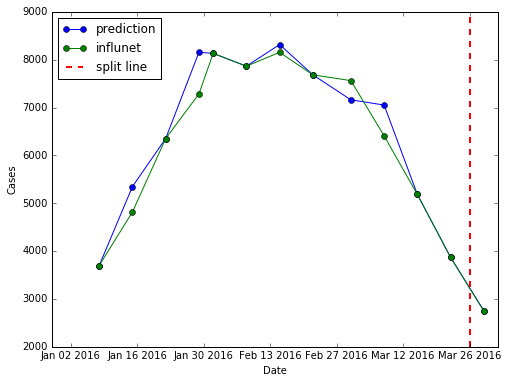

In [43]:
#it follows the prediction computation with cross validation

num_of_selected = len(df_x_y.columns)-2
betas = np.zeros((len(test_sets),num_of_selected+1))
i = 0
for x in zip(test_sets,train_sets):
    train_wiki = x[1][1]
    test_wiki = x[0][1]

    train_influ = x[1][0]
    test_influ = x[0][0]

    lr = sklearn.linear_model.LinearRegression()
    lr = lr.fit(train_wiki,train_influ)

    betas[i,:num_of_selected]=lr.coef_
    betas[i,num_of_selected] = lr.intercept_
    i +=1
conca = []
for j in range(0,num_of_selected+1):
    conca.append(np.mean(betas[:,j]))
conca=np.array(conca)
war_matrix = np.c_[ matrix_df[:,:num_of_selected], np.ones(len(matrix_df))] 
pred = np.dot(war_matrix,conca)
rmse_error = RMSE(pred)

df_copy = df_x_y.copy()
print
print 'RMSE:', rmse_error
print
df_copy["pred_norm"] = pred
sommaInflunet = np.sum(df_grTr['Totale_Casi'][1:num_av_week])
plt.figure(figsize=(8, 6))
plt.xlim([pd.Timestamp("2015-12-29"),pd.Timestamp("2016-04-01")])
plt.plot(df_copy["pred_norm"]*sommaInflunet, marker = 'o', label= "prediction")
plt.plot(df_x_y['Influnet_norm']*sommaInflunet, marker = 'o', label='influnet')
plt.axvline(x=pd.Timestamp("2016-03-26"),linestyle ='dashed', color='r',linewidth=2.0, label="split line")
plt.legend(loc=2)
plt.ylabel('Cases')
plt.xlabel('Date')
plt.show()